# Plus = add interannual variablity,Analysis of Monthly Mean Historical Meteorologic Variables from LOCA and BCSD

This notebook analyzes meteorologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective gridded observations used for training -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Precipitation
- Temperature

In [1]:
from loca import print_date
print_date()

Last executed: 2019-06-10 17:29:33.939363 by jvano on r6i6n33


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_historical_met_datasets, load_daily_livneh_meteorology, resample_monthly_data
from loca.utils import calc_change

# models = ['ACCESS1-0', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
# models = ['CCSM4', 'CNRM-CM5']
# models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
# models = ['ACCESS1-0', 'CanESM2'] 
# models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1']

# list of 20, without issues"
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4', 'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G']

# list of 25, without issues:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
#           'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']
# models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1'] #current 5
models = ['ACCESS1-0', 'CanESM2'] #testing

met_vars = ['pcp', 't_mean']

#cache is written in script xxx (TODO need to move it to its own script)
read_cache = True

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

OSError: Timed out trying to connect to 'tcp://10.148.10.19:40139' after 10 s: in <distributed.comm.tcp.TCPConnector object at 0x2aaad7de9160>: ConnectionRefusedError: [Errno 111] Connection refused

In [5]:
# # attempt reading in obs - see next few slides... much better to put it 
# DEFAULT_RESOLUTION = '8th'

# def load_monthly_obs_met_datasets(resolution=DEFAULT_RESOLUTION,
#                                          models=None, **kwargs):
#     print('load_monthly_historical_met_datasets', flush=True)

#     data['livneh'] = load_monthly_livneh_meteorology(resolution=resolution,
#                                                      **kwargs)
#     data['maurer'] = load_monthly_maurer_meteorology(resolution=resolution,
#                                                      **kwargs)

#     return data


In [5]:
# met_obs_data = load_monthly_obs_met_datasets(models=models, autoclose=True, parallel=True)

# Load Data

In [4]:
hist_cmip_met_data = {}
if read_cache:
    print("reading values from cache")
    for key in ['loca', 'bcsd']:
        hist_cmip_met_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    print("finished reading from cache")
    ds = hist_cmip_met_data['loca']
    print(ds['pcp'])
    #TODO once get obs load separate won't have to do work around below
    single = ['ACCESS1-0']
    obs_data = load_monthly_historical_met_datasets(models=single, autoclose=True, parallel=True)
    print("finished reading obs")

else:
    print("reading values from files directly")
    met_data = load_monthly_historical_met_datasets(models=models, autoclose=True, parallel=True)

reading values from cache
finished reading from cache
<xarray.DataArray 'pcp' (gcm: 25, time: 672, lat: 224, lon: 464)>
dask.array<shape=(25, 672, 224, 464), dtype=float64, chunksize=(1, 72, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * gcm      (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
load_monthly_historical_met_datasets
load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology
load_monthly_bcsd_meteorology
load_bcsd_dataset
load_monthly_livneh_meteorology
load_daily_livneh_meteorology
load_monthly_maurer_meteorology
load_daily_maurer_meteorology
finished reading obs


In [6]:
# merging
met_data = {**obs_data, **hist_cmip_met_data}

#list(met_data.keys())
#print(met_data)

In [8]:
# hist_cmip_met_data['bcsd']
# hist_cmip_met_data['bcsd']['pcp'].isel(gcm=0, time=0).plot()

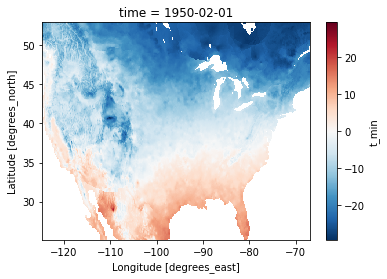

In [7]:
met_data['maurer']['t_min'].isel(time=1).plot()
# met_data['maurer']['pcp'].isel(time=1).plot()

In [7]:
# client.restart()

In [8]:
yr_type = 'A'  # either W for water year or A for calendar year, important is A for interannual variability eval
# epoch = slice('1969-10-01', '1999-09-30') # updated to be water year
epoch = slice('1970-01-01', '1999-12-31') # annual year 
print("finished slice")

# mask = met_data['maurer']['t_mean'].isel(time=0).squeeze().notnull()
# Use mask for maurer for all figs so difference plot ok
mask = met_data['bcsd']['t_mean'].isel(gcm=0, time=0).squeeze().notnull()

epoch_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS',
                                             chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in met_data.items())
print("finished epoch_means")
ens_means = {"bcsd": epoch_means['bcsd'].mean('gcm'),"loca": epoch_means['loca'].mean('gcm')}

# ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())
print("finished ens means mean")
# ens_mean_std = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').std('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())
ens_means_std = {"bcsd": epoch_means['bcsd'].std('gcm'),"loca": epoch_means['loca'].std('gcm')}
print("finished ens mean std")

# for debugging
# epoch_means = {}
# for k, ds in met_data.items():
#     print(k, flush=True)
#     epoch_means[k] = ds.sel(time=epoch).mean('time').where(mask).compute()

finished slice
finished epoch_means
finished ens means mean
finished ens mean std


In [9]:
# calculate interannual variability
# from Ethan: ds["pcp"].resample(time="YS").sum(dim="time").std(dim="time"
                                          
epoch_interannual = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS',
                                                   chunks={'lat': 100, 'lon': 100}).std('time').where(mask).persist()) for (k, ds) in met_data.items())
print("finished epoch_interannual")

# ens_interannual_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', 
#                                                        chunks={'lat': 100, 'lon': 100}).std('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())

ens_interannual_means  = {"bcsd": epoch_interannual['bcsd'].mean('gcm'),"loca": epoch_interannual['loca'].mean('gcm')}
print("finished ens interannual mean")

# ens_interannual_std = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', 
#                                                        chunks={'lat': 100, 'lon': 100}).std('time').std('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())
ens_interannual_std = {"bcsd": epoch_interannual['bcsd'].std('gcm'),"loca": epoch_interannual['loca'].std('gcm')}
print("finished ens interannual std")

finished epoch_interannual
finished ens interannual mean
finished ens interannual std


# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [10]:
kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

In [8]:
# ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

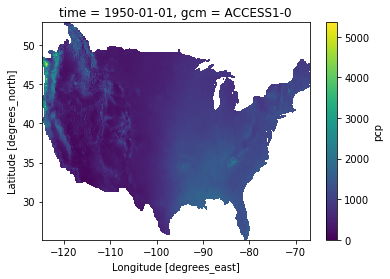

In [11]:
epoch_means['maurer']['pcp'].plot() 

In [ ]:
# Ensemble added (FIG A and B)

kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

nrows = 2 + len(models)
ncols = 2

# met_vars = ['t_mean', 'pcp']
met_vars = ['pcp']
for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ensemble, ds_data) in enumerate([('BCSD', epoch_means['maurer'], ens_means['bcsd'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], ens_means['loca'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('OBS')
        
        ax = axes[1, col]
        ensemble[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        if col == 0:
            ax.set_ylabel('Ensemble Mean')
        
        for row, model in enumerate(models, 2):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.0)
    fig.tight_layout()     
#     fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_ens_30{yr_type}Ys.png', dpi=300, bbox_inches='tight')

KeyboardInterrupt: 

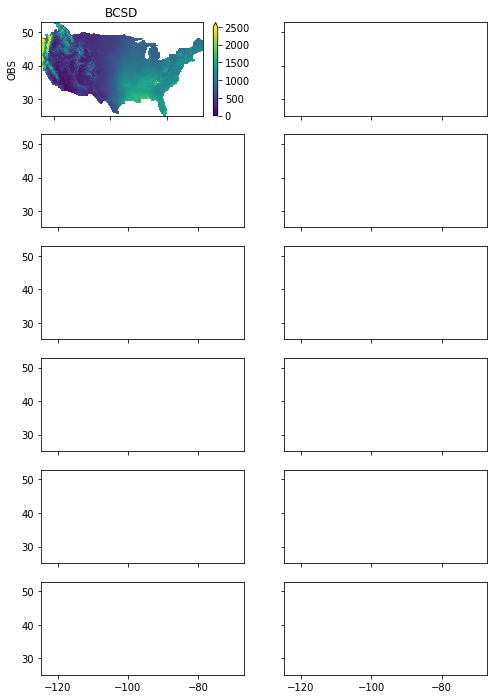

In [15]:
# NEW Ensemble added for mean and std (FIG A and B)

models = ['ACCESS1-0', 'CanESM2', 'MIROC5']

kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

nrows = 3 + len(models)
ncols = 2


# met_vars = ['t_mean', 'pcp']
met_vars = ['pcp']
for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ensemble_mean, ensemble_std, ds_data) in enumerate([('BCSD', epoch_means['maurer'], ens_means['bcsd'], ens_means_std['bcsd'],epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], ens_means['loca'],  ens_means_std['loca'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('OBS')
        
        ax = axes[1, col]
        ensemble_mean[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        if col == 0:
            ax.set_ylabel('Ensemble Mean')
            
        ax = axes[2, col]
        ensemble_std[var].plot.pcolormesh(ax=ax, add_labels=False, vmin=0, vmax=250)
        if col == 0:
            ax.set_ylabel('Ensemble St Dev')
        
        for row, model in enumerate(models, 3):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.0)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_ens_stdv_30{yr_type}Ys.png', dpi=300, bbox_inches='tight')

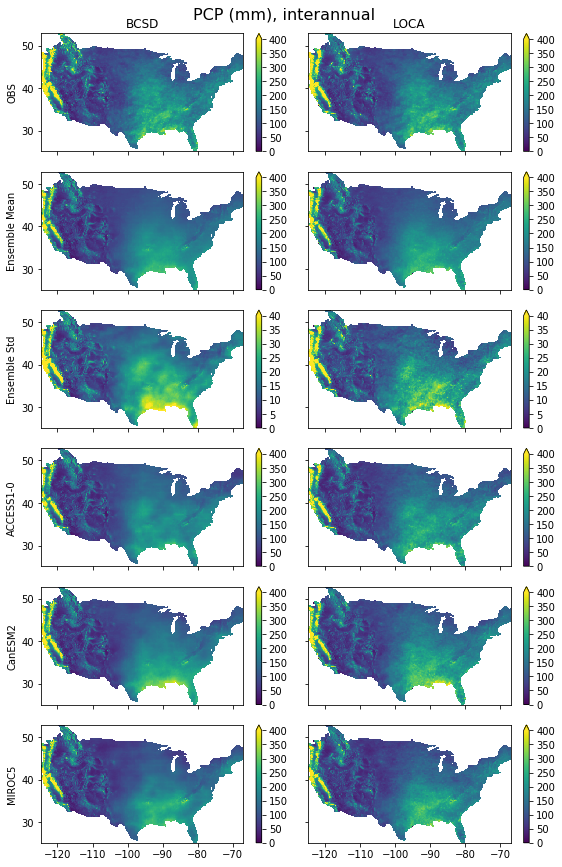

In [12]:
# NEW: Interannual Variability (but not use)

models = ['ACCESS1-0', 'CanESM2', 'MIROC5']

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
#           'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

kwargs = {'pcp': {'vmin': 0, 'vmax': 400},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

nrows = 3 + len(models)
ncols = 2

# met_vars = ['t_mean', 'pcp']
met_vars = ['pcp']
for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        
    for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], ens_interannual_means['bcsd'], ens_interannual_std['bcsd'], epoch_interannual['bcsd']),
                                                                         ('LOCA', epoch_interannual['livneh'], ens_interannual_means['loca'], ens_interannual_std['loca'], epoch_interannual['loca'])]):

#     for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], epoch_interannual['maurer'], epoch_interannual['maurer'], epoch_interannual['bcsd']),
#                                                                          ('LOCA', epoch_interannual['livneh'], epoch_interannual['livneh'], ens_interannual_std['loca'], epoch_interannual['loca'])]):

        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('OBS')
        
        ax = axes[1, col]
        ens_mean[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        if col == 0:
            ax.set_ylabel('Ensemble Mean')
            
        ax = axes[2, col]
#         ens_std[var].plot.pcolormesh(ax=ax, add_labels=False)
        ens_std[var].plot.pcolormesh(ax=ax, add_labels=False, vmin=0, vmax=40)
        if col == 0:
            ax.set_ylabel('Ensemble Std')
        
        for row, model in enumerate(models, 3):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
            
    title = var.upper()
    title += ' (%s), interannual' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.0)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_ens_interannual_30{yr_type}Ys.png', dpi=300, bbox_inches='tight')

'test3'

'test4'

'test4'

'test1'

'test2'

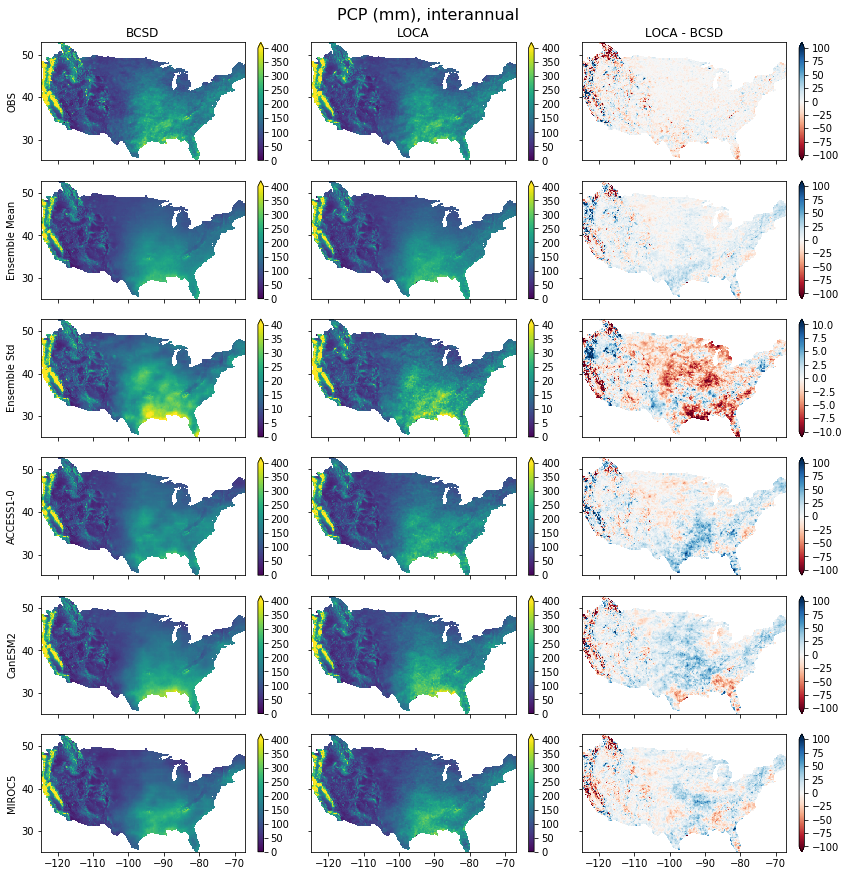

In [13]:
# NEW WORKING ON: Interannual Variability, with differences  USING 

models = ['ACCESS1-0', 'CanESM2', 'MIROC5']

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
#           'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

kwargs = {'pcp': {'vmin': 0, 'vmax': 400},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

diff_kws = {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}

nrows = 3 + len(models)
ncols = 3

# met_vars = ['t_mean', 'pcp']
met_vars = ['pcp']
for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        
    for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], ens_interannual_means['bcsd'], 
                                                                          ens_interannual_std['bcsd'], epoch_interannual['bcsd']),
                                                                         ('LOCA', epoch_interannual['livneh'], ens_interannual_means['loca'], 
                                                                          ens_interannual_std['loca'], epoch_interannual['loca'])]):

#     for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], epoch_interannual['maurer'], epoch_interannual['maurer'], epoch_interannual['bcsd']),
#                                                                          ('LOCA', epoch_interannual['livneh'], epoch_interannual['livneh'], ens_interannual_std['loca'], epoch_interannual['loca'])]):

        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('OBS')
            display ('test3')
            
        
        ax = axes[1, col]
        ens_mean[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
#         ens_mean[var].plot.pcolormesh(ax=ax, add_labels=False)
        if col == 0:
            ax.set_ylabel('Ensemble Mean')
            display ('test4')
            
        ax = axes[2, col]
#         ens_std[var].plot.pcolormesh(ax=ax, add_labels=False)
        ens_std[var].plot.pcolormesh(ax=ax, add_labels=False, vmin=0, vmax=40)
        if col == 0:
            ax.set_ylabel('Ensemble Std')
            display ('test4')
        
        for row, model in enumerate(models, 3):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    display ('test1')
# ATTEMPT TO ADD DIFF        
    ax = axes[0, -1]
    calc_change(epoch_interannual['maurer'][var], epoch_interannual['livneh'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
    ax.set_title('LOCA - BCSD')  
        
    ax = axes[1, -1]
    calc_change(ens_interannual_means['bcsd'][var], ens_interannual_means['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])

    ax = axes[2, -1]
    calc_change(ens_interannual_std['bcsd'][var], ens_interannual_std['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, vmin=-10, vmax=10, cmap= 'RdBu')

    diff = calc_change(epoch_interannual['bcsd'][var], epoch_interannual['loca'][var]).persist()
    display ('test2')
    for row, model in enumerate(models, 3):
        ax = axes[row, -1]  
        diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])

    title = var.upper()
    title += ' (%s), interannual' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.01)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_ens_interannual_wDiff_30{yr_type}Ys.png', dpi=300, bbox_inches='tight')

In [ ]:
# display (ens_std[var])
# display (ens_means_std)
# display (ens_means)


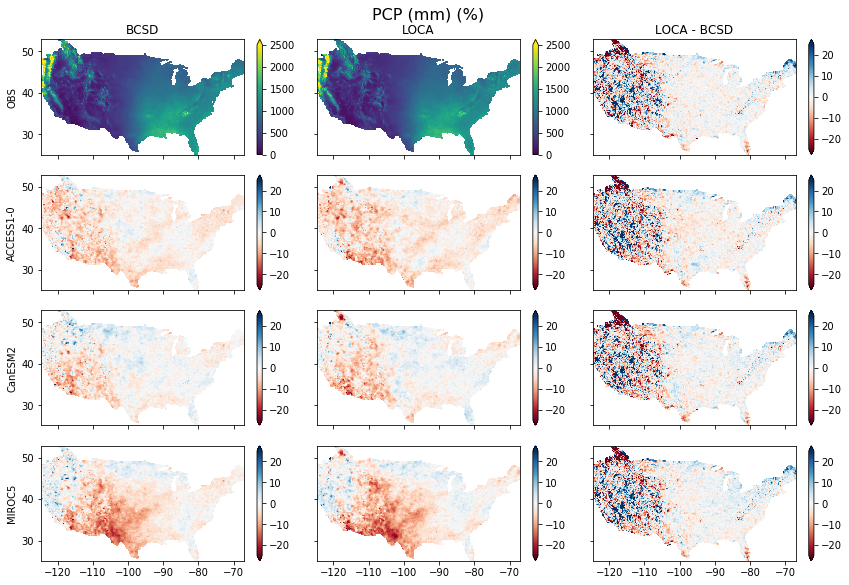

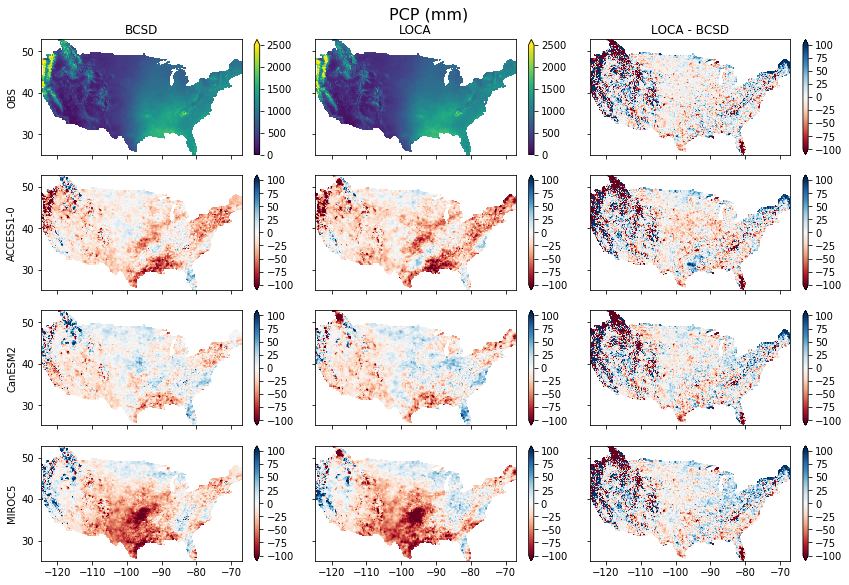

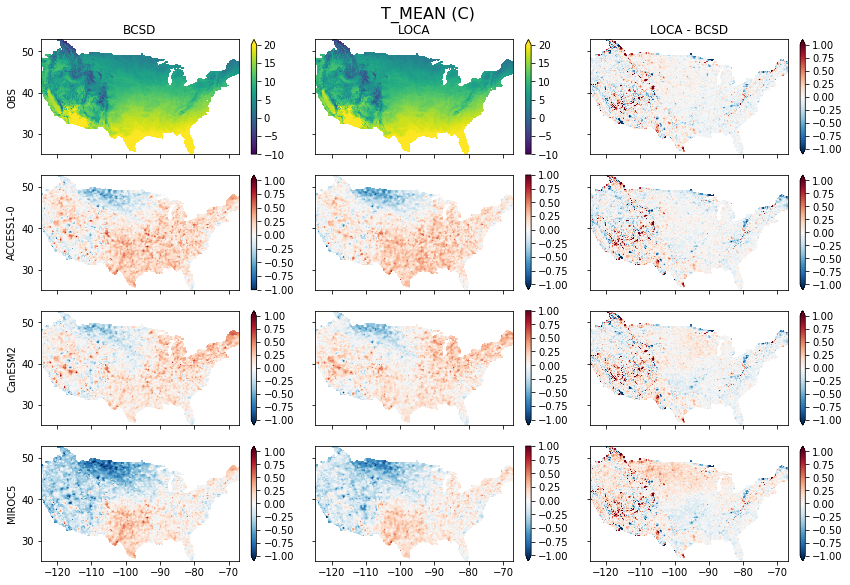

In [33]:
# FIG C and D

kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

met_vars = ['pcp', 't_mean']
# met_vars = ['pcp']

units = {'pcp': 'mm', 't_mean': 'C'}

nrows = 1 + len(models)
ncols = 2

diff_kws = {False: {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu'}}}

for var in met_vars:
    
    for pct in [True, False]:
  
        if var not in diff_kws[pct]:
            continue
    
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        ax.set_title('LOCA - BCSD')  

        diff = calc_change(epoch_means['bcsd'][var], epoch_means['loca'][var], pct=pct).persist()
        for row, model in enumerate(models, 1):
            ax = axes[row, -1]  
            diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

            
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_historic_met_30{yr_type}Ys.png', dpi=300, bbox_inches='tight')

KilledWorker: ('open_dataset-9dca01fc9e17b8a0202f1a7a6bc8290bPrcp-bf52f6b20b5ad55ee1953afb5837fd4a', 'tcp://10.148.9.183:34647')

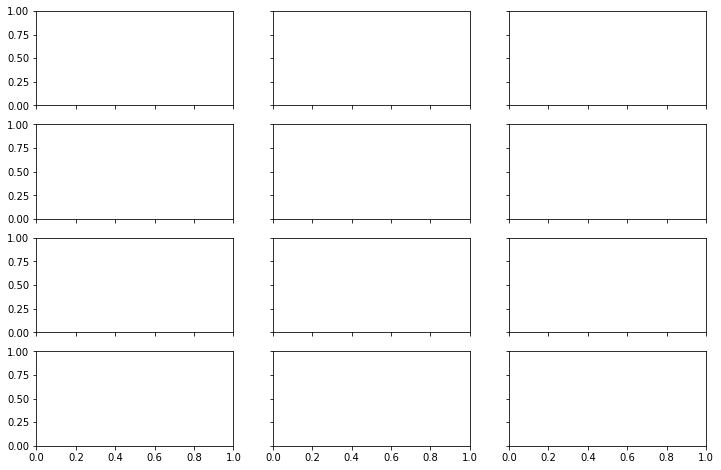

In [34]:
# FIG C and D FOR INTERANNUAL VARIABILITY

kwargs = {'pcp': {'vmin': 0, 'vmax': 400},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

# met_vars = ['pcp', 't_mean']
met_vars = ['pcp']

units = {'pcp': 'mm', 't_mean': 'C'}

nrows = 1 + len(models)
ncols = 2


diff_kws = {False: {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu'}}}


for var in met_vars:
    
    for pct in [False]:
  
        if var not in diff_kws[pct]:
            continue
    
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], epoch_interannual['bcsd']),
                                                          ('LOCA', epoch_interannual['livneh'], epoch_interannual['loca'])]):

            ax = axes[0, col]
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        ax.set_title('LOCA - BCSD')  

        diff = calc_change(epoch_means['bcsd'][var], epoch_means['loca'][var], pct=pct).persist()
        for row, model in enumerate(models, 1):
            ax = axes[row, -1]  
            diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

            
        title = var.upper()
        title += ' (%s), interannual' % units[var]
        if pct:
            title += ' (%) interannual'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_historic_met_interannual_30{yr_type}Ys.png', dpi=300, bbox_inches='tight')
      

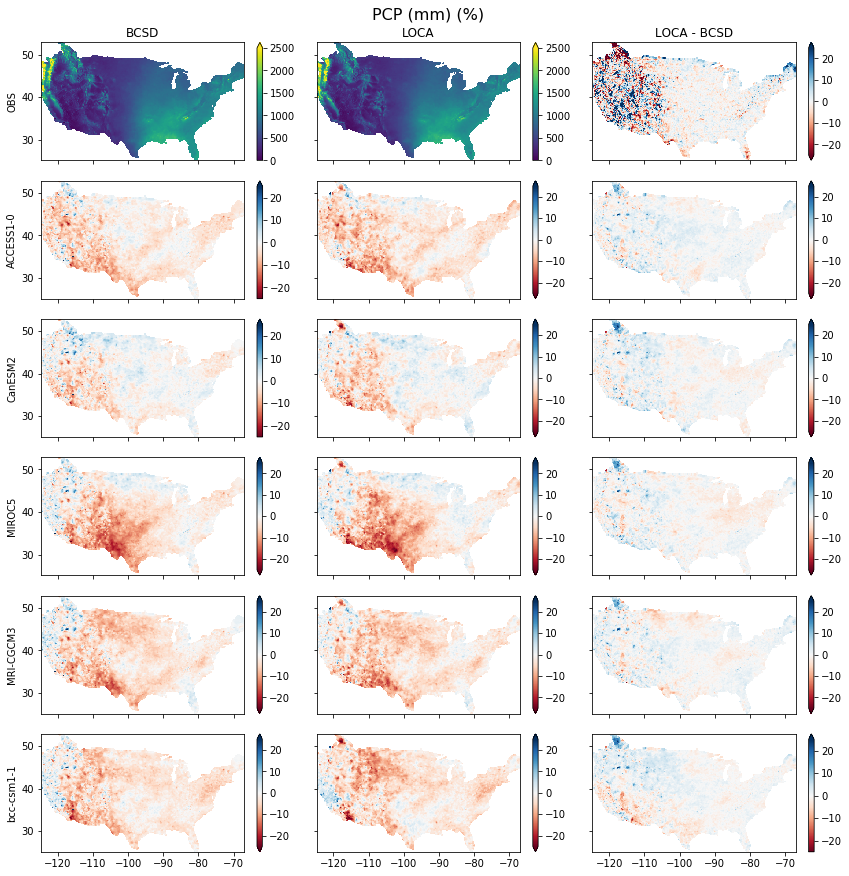

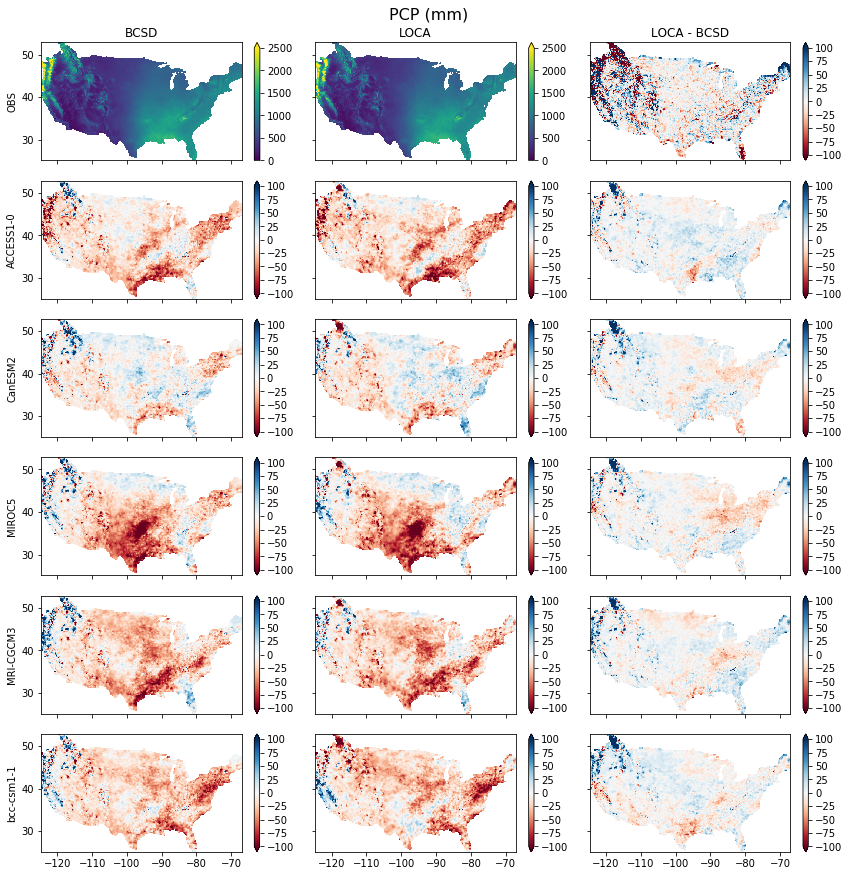

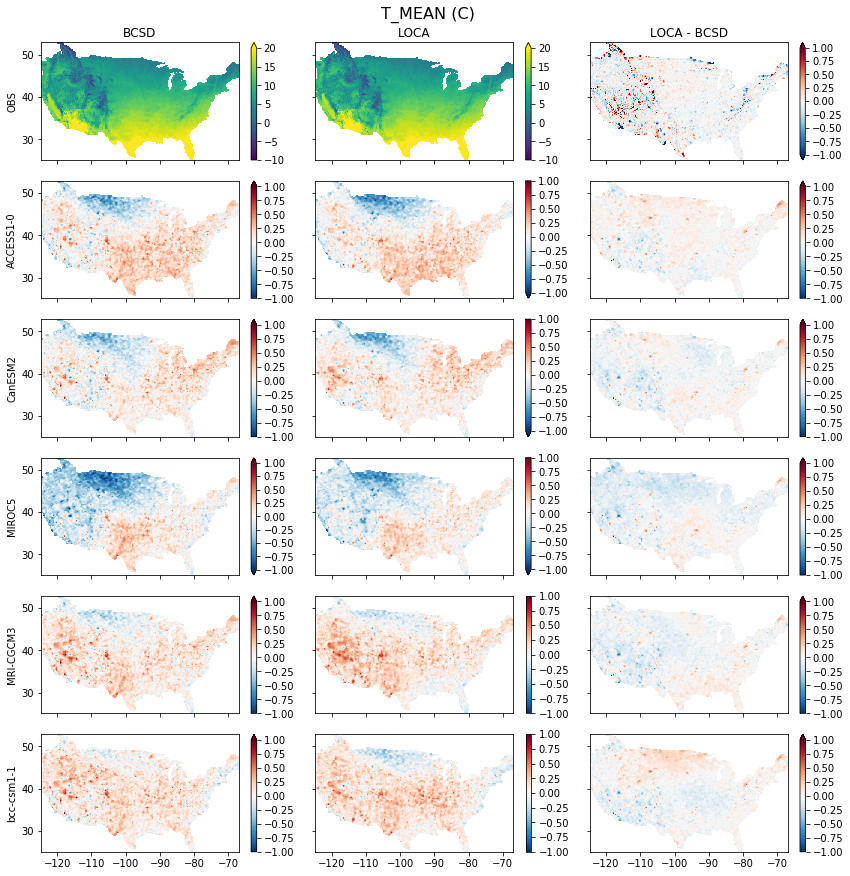

In [17]:
cache = {}

nrows = 1 + len(models)
ncols = 2

for var in met_vars:
    
    for pct in [True, False]:
        
        if var not in diff_kws[pct]:
            continue
    

        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                cache[(row, col)] = diff.sel(gcm=model)
                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        ax.set_title('LOCA - BCSD')

        for row, model in enumerate(models, 1):
            ax = axes[row, -1]
            diff = cache[(row, 0)] - cache[(row, 1)] #DIFF OF A DIFF JAV, right?
            diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

            
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff2_{var}_{unit_str}_monthly_historic_met_30{yr_type}Ys.png', dpi=300, bbox_inches='tight')

In [ ]:
#DON'T USE

nrows = 1 + len(models)
ncols = 2

for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
        if col == 0:
            ax.set_ylabel('OBS')
        
        ax.set_title(title)
        
        for row, model in enumerate(models, 1):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.0)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_30{yr_type}Ys.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')